/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


Epoch 1/50 - Train Loss: 0.3924, Train Acc: 0.8599, Val Loss: 0.4941, Val Acc: 0.8775
Epoch 2/50 - Train Loss: 0.1789, Train Acc: 0.9378, Val Loss: 0.4351, Val Acc: 0.8574
Epoch 3/50 - Train Loss: 0.1569, Train Acc: 0.9451, Val Loss: 0.3775, Val Acc: 0.8810
Epoch 4/50 - Train Loss: 0.1310, Train Acc: 0.9554, Val Loss: 0.2757, Val Acc: 0.9213
Epoch 5/50 - Train Loss: 0.0847, Train Acc: 0.9722, Val Loss: 0.2288, Val Acc: 0.9213
Epoch 6/50 - Train Loss: 0.0924, Train Acc: 0.9691, Val Loss: 0.1113, Val Acc: 0.9580
Epoch 7/50 - Train Loss: 0.0558, Train Acc: 0.9805, Val Loss: 0.4156, Val Acc: 0.8950
Epoch 8/50 - Train Loss: 0.0270, Train Acc: 0.9904, Val Loss: 0.0587, Val Acc: 0.9834
Epoch 9/50 - Train Loss: 0.0174, Train Acc: 0.9941, Val Loss: 0.0483, Val Acc: 0.9860
Epoch 10/50 - Train Loss: 0.0119, Train Acc: 0.9963, Val Loss: 0.0475, Val Acc: 0.9878
Epoch 11/50 - Train Loss: 0.0102, Train Acc: 0.9963, Val Loss: 0.0522, Val Acc: 0.9860
Epoch 12/50 - Train Loss: 0.0108, Train Acc: 0.9969,

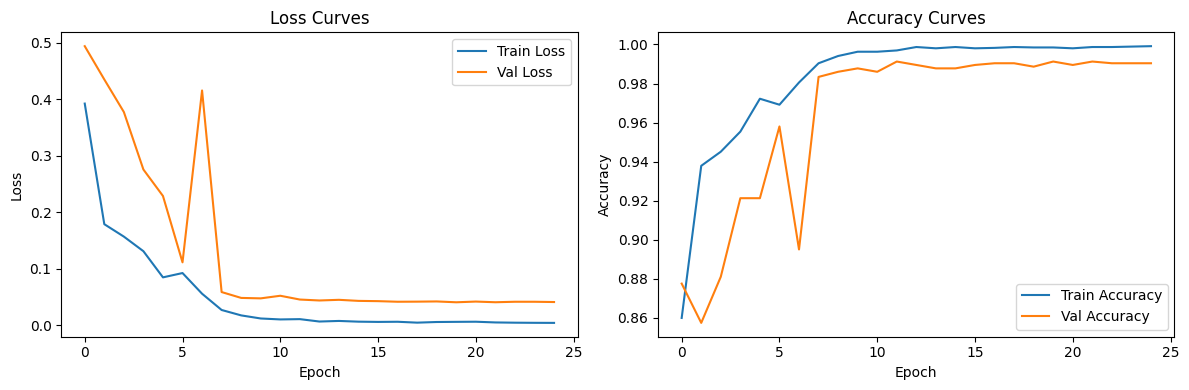

Test Accuracy: 0.9931


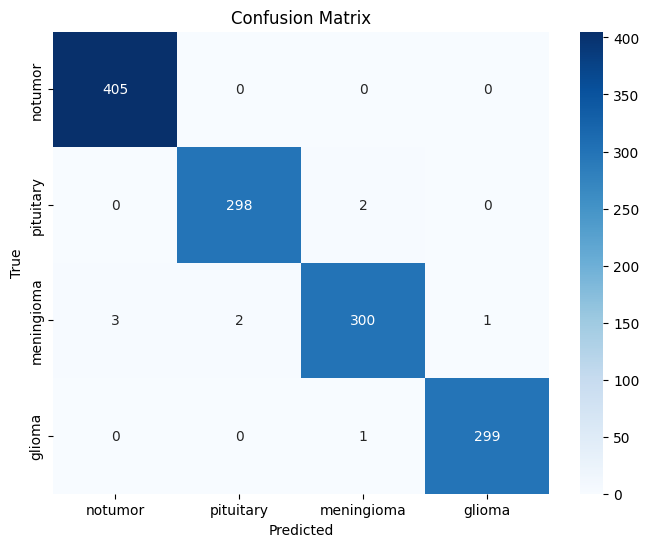

In [1]:
# Import necessary libraries for data handling, image processing, deep learning, and visualization
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset path (update as needed)
USER_PATH = r"/kaggle/input/brain-tumor-mri-dataset"

# Custom Dataset Class for loading and preprocessing MRI images
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'notumor': 0, 'pituitary': 1, 'meningioma': 2, 'glioma': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label = self.label_map[self.dataframe.iloc[idx]['label']]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# CBAM (Convolutional Block Attention Module) for attention mechanism
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction_ratio, 1)
        self.fc2 = nn.Conv2d(in_channels // reduction_ratio, in_channels, 1)
        self.sigmoid = nn.Sigmoid()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm2d(1)

    def forward(self, x):
        avg_out = self.fc2(self.fc1(self.avg_pool(x)))
        max_out = self.fc2(self.fc1(self.max_pool(x)))
        channel_out = self.sigmoid(avg_out + max_out)
        x = x * channel_out

        avg_spatial = torch.mean(x, dim=1, keepdim=True)
        max_spatial, _ = torch.max(x, dim=1, keepdim=True)
        spatial_out = torch.cat([avg_spatial, max_spatial], dim=1)
        spatial_out = self.sigmoid(self.bn(self.conv(spatial_out)))
        x = x * spatial_out

        return x

# ResNet with CBAM integration for enhanced feature extraction
class ResNetCBAM(nn.Module):
    def __init__(self, num_classes=4):
        super(ResNetCBAM, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.cbam1 = CBAM(256)
        self.cbam2 = CBAM(512)
        self.cbam3 = CBAM(1024)
        self.cbam4 = CBAM(2048)
        self.resnet.layer1 = nn.Sequential(self.resnet.layer1, self.cbam1)
        self.resnet.layer2 = nn.Sequential(self.resnet.layer2, self.cbam2)
        self.resnet.layer3 = nn.Sequential(self.resnet.layer3, self.cbam3)
        self.resnet.layer4 = nn.Sequential(self.resnet.layer4, self.cbam4)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Function to load dataset from directory structure
def load_dataset(path):
    data = []
    for split in ['Training', 'Testing']:
        split_path = os.path.join(path, split)
        for tumor_type in os.listdir(split_path):
            tumor_path = os.path.join(split_path, tumor_type)
            if os.path.isdir(tumor_path):
                for img_name in os.listdir(tumor_path):
                    if img_name.endswith(('.jpg', '.png', '.jpeg')):
                        data.append({
                            'image_path': os.path.join(tumor_path, img_name),
                            'label': tumor_type,
                            'split': split
                        })
    return pd.DataFrame(data)

# Define data preprocessing transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split dataset into train, validation, and test sets
data = load_dataset(USER_PATH)
train_data = data[data['split'] == 'Training']
test_data = data[data['split'] == 'Testing']
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

# Create dataset instances
train_dataset = BrainTumorDataset(train_data, transform=train_transform)
val_dataset = BrainTumorDataset(val_data, transform=test_transform)
test_dataset = BrainTumorDataset(test_data, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=112, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=112, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=112, shuffle=False)

# Initialize model, loss function, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetCBAM(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop function with early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step()
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            best_model_state = model.state_dict()
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                model.load_state_dict(best_model_state)
                break

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

# Plot training and validation curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation function on test set
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['notumor', 'pituitary', 'meningioma', 'glioma'],
                yticklabels=['notumor', 'pituitary', 'meningioma', 'glioma'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the model
evaluate_model(model, test_loader)
